In [1]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

# Building Bear Classifier Model

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '154dc8f8de094d678f48aee49a775c8d')

Create `bears` directory and download images from `Bing` 

In [9]:
bear_types = 'grizzly', 'black', 'teddy', 'polar'
path = Path('bears')
bear_types

('grizzly', 'black', 'teddy', 'polar')

In [6]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#386) [Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000110.jpg'),Path('bears/grizzly/00000112.jpg'),Path('bears/grizzly/00000091.jpg'),Path('bears/grizzly/00000093.jpg'),Path('bears/grizzly/00000090.jpg')...]

There might be some images that are corrupt. So we need to check and delete from our data

In [113]:
failed = verify_images(fns)
failed

(#0) []

In [114]:
failed.map(Path.unlink)

(#0) []

In [115]:
def get_y(o):
    return [Path(o).parent.name] 
#because we are using MultiCategoryBlock, so the labels is assumed to be a list, so we need to return our labels as a list

Now, we create template for "data holder"

In [10]:
bears = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)    
)

Next, we load images by using dataloaders

In [11]:
dls = bears.dataloaders(path)

Using `show_batch` to check some of the images before train our model

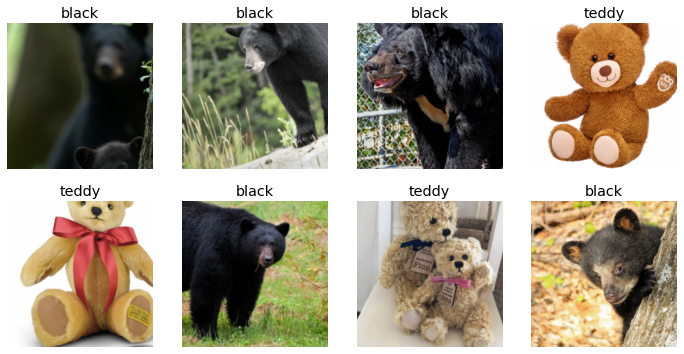

In [12]:
dls.show_batch(max_n=8, nrows=2, unique=False)

Now, we train our very first model 

In [13]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.9))
learn.fine_tune(5, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.021321,0.712310,0.718615,00:16
1,0.764472,0.186448,0.965368,00:15
2,0.543591,0.099119,0.978355,00:15


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.103001,0.096849,0.978355,00:16
1,0.091524,0.083287,0.978355,00:17
2,0.074216,0.065415,0.978355,00:16
3,0.059997,0.058445,0.978355,00:17
4,0.051328,0.052506,0.978355,00:16


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

Let's see what makes our model confused the most

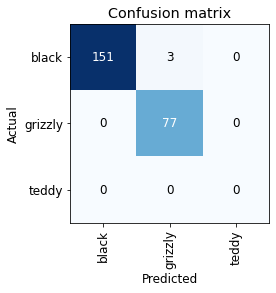

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

By using `plot_top_losses` function, we can get the wrong prediction as well as the one that our model is least confident of

,target,predicted,probabilities,loss
0,black,black;grizzly,"tensor([0.6179, 0.9843, 0.0026])",1.54630446434021
1,black,black;grizzly,"tensor([0.8746, 0.9365, 0.0031])",0.9646903872489929
2,grizzly,black;grizzly,"tensor([9.2937e-01, 9.8197e-01, 3.2731e-04])",0.8896290063858032
3,teddy,teddy,"tensor([2.4423e-01, 2.8308e-04, 9.9998e-01])",0.09343942999839783
4,black,black,"tensor([0.9983, 0.1894, 0.0175])",0.07642104476690292


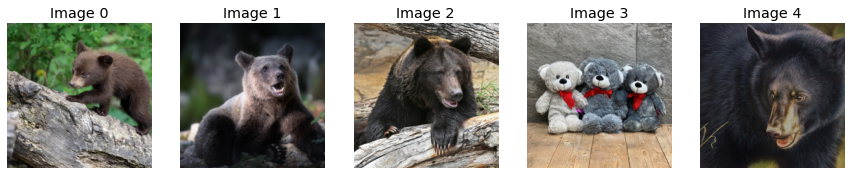

In [15]:
interp.plot_top_losses(5, nrows=1)

Now, it's time to look at the data and do some cleaning

In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


After making some changes on `cleaner`, we should, then, tell the computer to apply those changes

In [25]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
    if not (path/cat).exists():
        shutil.move(str(cleaner.fns[idx]), path/cat)

So it's time to train our model again!!!!

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0010000000474974513)

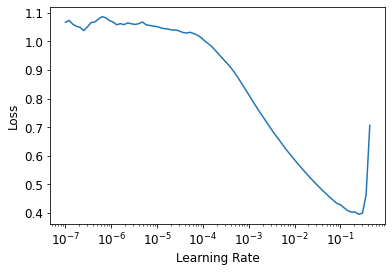

In [18]:
dls = bears.dataloaders(path)
learn= cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.9))
learn.lr_find()

In [88]:
dls = bears.dataloaders(path)
learn= cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.9))
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.857238,0.432527,0.722944,00:14
1,0.614023,0.117995,0.987013,00:15
2,0.434469,0.089239,0.982684,00:16


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.064253,0.099035,0.974026,00:16
1,0.052662,0.106523,0.982684,00:16
2,0.042806,0.076994,0.991342,00:15
3,0.035335,0.056192,0.991342,00:15


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

As we can see, our model are getting better after some changes are made on the data

Finally, we can save our model by using `export`

In [90]:
learn.export()

our model is saved on the file called `export.pkl`

In [91]:
modelPath = Path()
modelPath.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [92]:
learn.inf = load_learner(modelPath/'export.pkl')

In [24]:
btn= widgets.FileUpload()
btn

FileUpload(value={}, description='Upload')

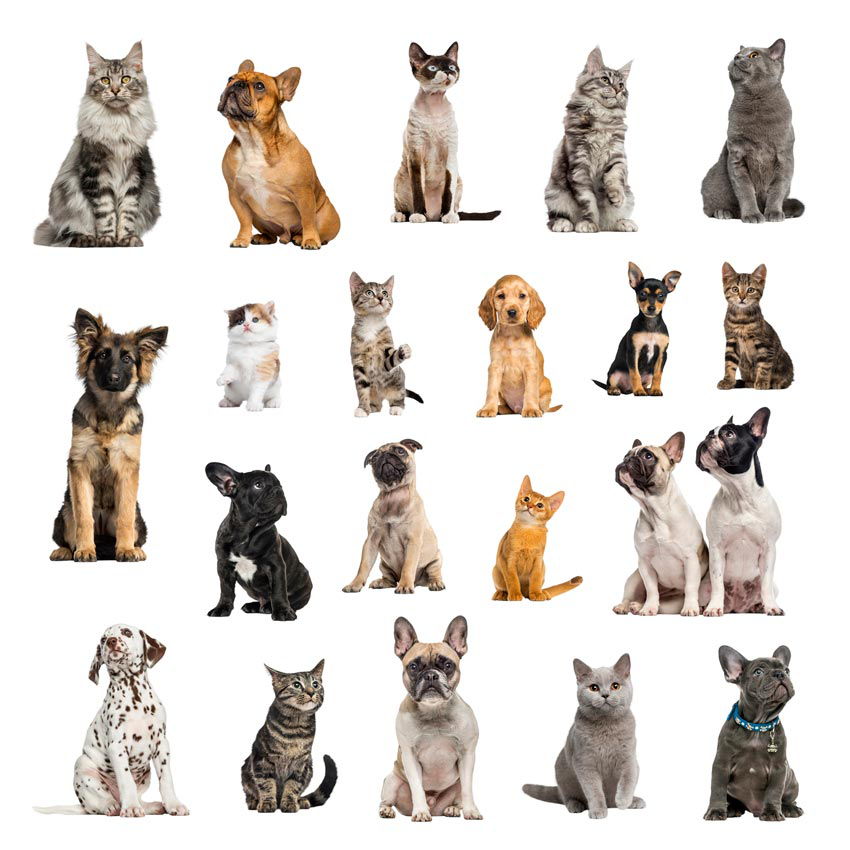

In [136]:
img = PILImage.create(btn.data[-1])
img

In [137]:
pred,pred_idx,probs = learn.inf.predict(img)

In [138]:
pred,pred_idx,probs

((#2) ['grizzly','teddy'],
 tensor([False,  True,  True]),
 tensor([0.0081, 0.8044, 0.9764]))

In [135]:
if(len(pred) > 0):
    print(f'Prediction: {pred[0]} bear; Probability: {probs[(pred_idx == True).nonzero(as_tuple=True)[0].item()]:.04f}')
else:
    print(f'Prediction: None')

Prediction: None
